In [1]:
import pandas as pd
from config import config
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

## Read training results

In [2]:
run_summary = pd.read_csv('results/training_results.csv').dropna()

## Track progress - strategy daily returns minus the index daily returns

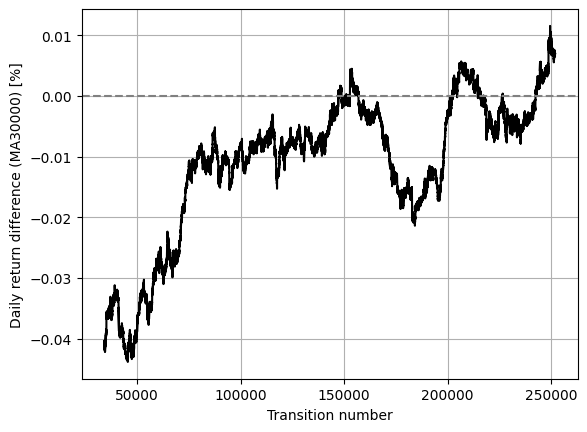

In [3]:
diff = run_summary['diffs'].dropna()
diff.rolling(30000).mean().plot(legend=False, color='black')
plt.xlabel('Transition number')
plt.ylabel('Daily return difference (MA30000) [%]')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.5)
plt.grid(True)
plt.savefig('charts/training_daily_returns_track_progress.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

## Track progress - daily strategy returns vs daily index returns 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


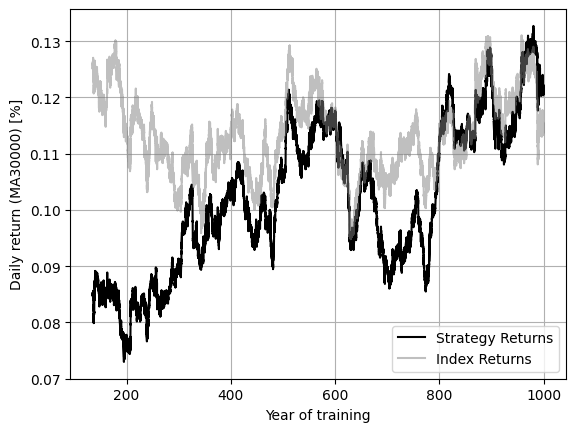

In [4]:
strategy_returns = pd.Series(run_summary['strategy_returns'].values, index=run_summary.index/252)
market_returns = pd.Series(run_summary['market_returns'].values, index=run_summary.index/252)
strategy_returns.rolling(30000).mean().plot(color='black')
market_returns.rolling(30000).mean().plot(color='gray', alpha=0.5)
plt.xlabel('Year of training')
plt.ylabel('Daily return (MA30000) [%]')
plt.grid(True)
plt.legend(['Strategy Returns', 'Index Returns'])
plt.savefig('charts/training_market_vs_strategy_ma30000.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

## Track convergence - mean Huber losses

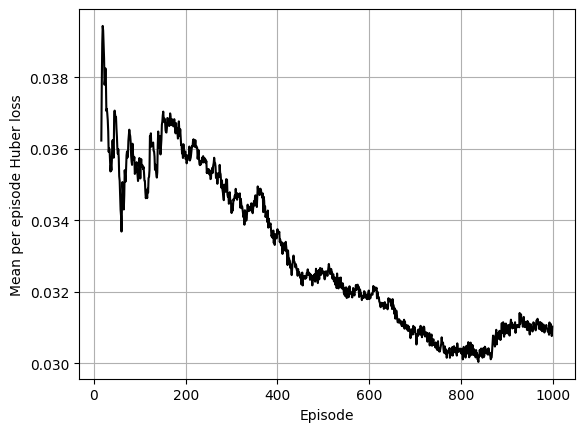

In [5]:
losses = run_summary['losses'].groupby(run_summary['losses'].index // config['trading_days']).first()
losses.plot(color='black')
plt.xlabel('Episode')
plt.ylabel('Mean per episode Huber loss')
plt.grid(True)
plt.savefig('charts/losses.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

## Track actions preference of the agent - running mean

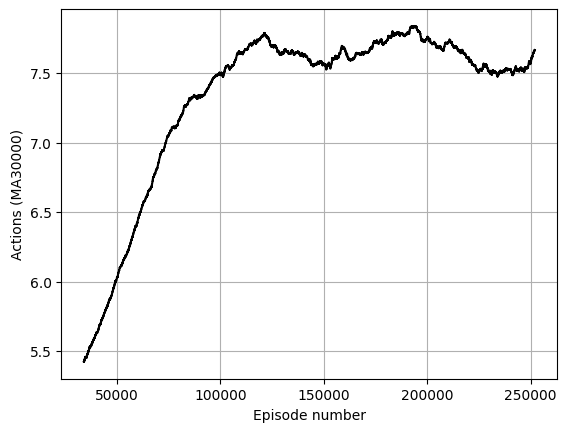

In [6]:
actions = run_summary['actions']
actions.rolling(30000).mean().plot(color='black')
plt.ylabel('Actions (MA30000)')
plt.xlabel('Episode number')
plt.grid(True)
plt.savefig('charts/training_actions_ma30000.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

## Validation of chosen actions and stop levels

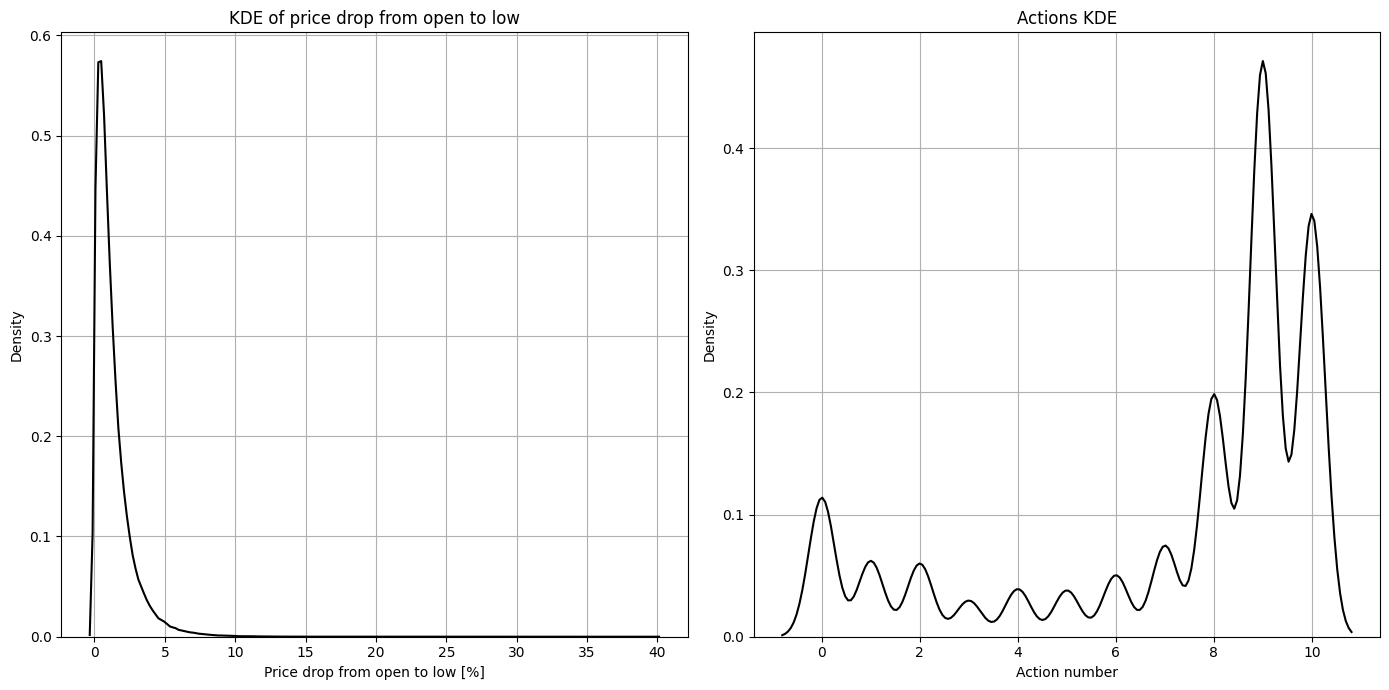

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Calculate open-to-low price drops
ol_diffs = pd.DataFrame()
tic_filename = Path('data/nasdaq_index_list_filtered.csv')
yf_filename = os.path.abspath('data/ohlcv/{}.csv')
tickers = pd.read_csv(tic_filename)['0'].to_list()
for s in tickers:
    ol_diffs = pd.concat([ol_diffs, pd.read_csv(yf_filename.format(s))])
ol_diffs = (ol_diffs['Open'] - ol_diffs['Low']) / ol_diffs['Open']

# First KDE plot on the first subplot
sns.kdeplot(ol_diffs * 100, ax=ax1, color='black', fill=False)
ax1.set_title('KDE of price drop from open to low')
ax1.set_ylabel('Density')
ax1.set_xlabel('Price drop from open to low [%]')
ax1.grid(True)

# Second KDE plot on the second subplot
sns.kdeplot(run_summary['actions'], ax=ax2, color='black', fill=False)
ax2.set_title('Actions KDE')
ax2.set_ylabel('Density')
ax2.set_xlabel('Action number')
ax2.grid(True)

# Adjust layout and display plots
plt.tight_layout()
plt.savefig('charts/actions_analysis.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()